Mask Model
-------

Basing this on the fast.ai Keras Tiramisu implementation of the One Hundred Layers Tiramisu as described in Simon Jegou et al.'s paper [The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation](https://arxiv.org/abs/1611.09326).

This is heavily inspired by the code from the 2nd Fast.ai Deep Learning course here:
https://github.com/fastai/courses/blob/master/deeplearning2/tiramisu-keras.ipynb

I've updated it to Keras 2 and have rewritten it to understand it.

In [2]:
%matplotlib inline
#import bcolz
import glob
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Dropout, concatenate, Conv2DTranspose, Reshape
from keras.regularizers import l2
import numpy as np
import os
import random
import threading
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from PIL import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/rallen/anaconda3/envs/dl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
def dense_block_down(x,nb_layers,growth_rate,p,wd):
    """See Figure 2 from th paper. A dense_block has nb_layers of 'Layer' blocks.  This function 
    takes in an input x, and returns two output variants: a modified x and a 'added' variable.  
    Note in Figure 1 where the down path has a post-DB concat to the x input and the up connection does not.  
    x becomes a concatenation of x and the intermediate layer outputs: [x,a,a',a'',a''',...] and 
    'added' variable is concatenated layer of only the layer outputs [a,a',a'',a''',...] 
    So this allows this one bit of code to work for both down and up connections.  
    
    Each layer is a described in Table 1 of the paper.  Batch Norm, ReLU, 3x3 Conv, Dropout (p=0.2)
    
    This seems like something we don't need to be so tricky about.  It could 
    be eating more memory than is necessary to make both variables.  
    But at the moment I don't know how to code keeping 
    an input to this function unmodified to "go around" this dense_block.
    """
    for i in range(nb_layers):
        a = BatchNormalization(axis=-1)(x)
        a = Activation('relu')(a)
        a = Conv2D(growth_rate, (3, 3),
                   padding="same", kernel_initializer="he_uniform", 
                   kernel_regularizer=l2(wd))(a)
        a = Dropout(p)(a) if p else a
        x = concatenate([x, a])
    return x

def dense_block_up(x,nb_layers,growth_rate,p,wd):
    """FIXME
    """
    for i in range(nb_layers):
        a = BatchNormalization(axis=-1)(x)
        a = Activation('relu')(a)
        a = Conv2D(growth_rate, (3, 3),
                   padding="same", kernel_initializer="he_uniform", 
                   kernel_regularizer=l2(wd))(a)
        a = Dropout(p)(a) if p else a
        x = concatenate([x, a])
        if i == 0:
            added = a
        else:
            added = concatenate([added,a]) 
    return added

def transition_down(x, p, wd, do_maxpool):
    """See Table 1 for the Transition Down block.  Similar to the Layer 
    in the DenseBlock, but slightly different with 1x1 Conv and 2x2 MaxPooling.
    Jeremy Howard's fast.ai code did not use MaxPooling, but rather just 2x strides,
    so allow for control of this via do_maxpool."""
    nb_filter = x.get_shape().as_list()[-1]
    conv_stride = 1 if do_maxpool else 2
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_filter, (1, 1),
               padding="same", kernel_initializer="he_uniform", 
               strides=(conv_stride, conv_stride),
               kernel_regularizer=l2(wd))(x)
    x = Dropout(p)(x) if p else x
    x = MaxPooling2D()(x) if do_maxpool else x
    return x

def transition_up(added, wd=0):
    """See Table 1 for the transition up block. A 3x3 Transposed Conv with stride=2."""
    _,r,c,ch = added.get_shape().as_list()
    x = Conv2DTranspose(ch, (3, 3), 
                        strides=(2, 2), 
                        padding="same", 
                        kernel_initializer="he_uniform", 
                        kernel_regularizer=l2(wd))(added)
    return x

def create_tiramisu_model(nb_classes, img_input, nb_layers_per_block, 
                          initial_filter=48, bottleneck_filter=15, growth_rate=16, 
                          do_td_maxpool=True, p=0.2, wd=1e-4):
    """create_tiramisu_model:
    inputs:
      nb_classes: number of output classes to classify
      img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
          that should match your K.image_data_format() == 'channels_first' setting.
      nb_layers_per_block: 
          items in list are number of layers in each dense block (not including bottleneck)
          e.g. [4,5,7,10,12] to match the paper.  Note that the last entry in the list 
          doesn't produce skips and the up path won't mirror it.
      initial_filter: number of filters in initial 3x3 Conv (48 per paper)
      bottleneck_filter: number of filters in bottleneck stage (15 per paper)
      growth_rate: number of filters to add per dense block (12 or 16 per paper)
      do_td_maxpool: Jeremy Howard says 
      p: dropout rate or None for no Dropout() (0.2 per paper)
      wd: weight decay (1e-4 per paper)
    output:
      Tiramisu Keras Model
    """

    assert type(nb_layers_per_block) == list
    
    # initial 3x3 Convolution
    x = Conv2D(initial_filter, (3, 3), padding="same", 
               kernel_initializer="he_uniform", 
               kernel_regularizer=l2(wd))(img_input)
 
    # Down Path: DenseBlocks + TransitionDowns
    skips = []
    for nb_layers in nb_layers_per_block:
        x = dense_block_down(x, nb_layers, growth_rate, p, wd)
        skips.append(x)
        x = transition_down(x, p, wd, do_td_maxpool)
    
    # Bottleneck
    added = dense_block_up(x, nb_layers, growth_rate, p, wd)
    
    # Up Path: TransitionUp + DenseBlocks
    skips = list(reversed(skips))
    nb_layers_per_block = list(reversed(nb_layers_per_block))
    for i,nb_layers in enumerate(nb_layers_per_block):
        x = transition_up(added, wd)
        x = concatenate([x,skips[i]])
        added = dense_block_up(x, nb_layers, growth_rate, p, wd)
    
    # final 1x1 Convolution & Softmax
    x = Conv2D(nb_classes, (1, 1), padding="same", 
               kernel_initializer="he_uniform", 
               kernel_regularizer=l2(wd))(x)
    x = Reshape((-1, nb_classes))(x)
    x = Activation('softmax')(x)
    return x

class image_generator(object):
    def __init__(self, X, Y, batch_size, channels):
        self.X  = X
        self.Y  = Y
        self.bs = batch_size
        self.i  = 0
    def __next__(self):
        xs = self.X[self.i:self.i+self.bs]
        ys = self.Y[self.i:self.i+self.bs]
        ys = ys.reshape(len(ys),-1,channels) # convert 32,64,64,1 -> 32,4096,1
        self.i = (self.i + self.bs) % self.X.shape[0]
        return xs, ys

Read in the training & validation images
-------

These are created via the mask_data_prep notebook

 - [ ] FIXME add testing of the test image set

In [4]:
# Remember to adjust 255 -> 1 on mask to convert it from a mask to a label
# 0=background, 1=inside staff
train_path = 'data/train'
train_score_image_names = glob.glob(train_path+'/diced_score*png')
train_mask_image_names = glob.glob(train_path+'/diced_mask*png')
train_score_image_names.sort()
train_mask_image_names.sort()
train_score_images = np.stack([np.array(Image.open(fn)) for fn in train_score_image_names])
train_mask_images = np.stack([np.array(Image.open(fn))//255 for fn in train_mask_image_names])
train_score_images.shape = train_score_images.shape + (1,)
train_mask_images.shape = train_mask_images.shape + (1,)
assert(train_score_images.shape == train_mask_images.shape)
num_train_images,rows,cols,channels = train_score_images.shape

In [5]:
valid_path = 'data/valid'
valid_score_image_names = glob.glob(valid_path+'/diced_score*png')
valid_mask_image_names = glob.glob(valid_path+'/diced_mask*png')
valid_score_image_names.sort()
valid_mask_image_names.sort()
valid_score_images = np.stack([np.array(Image.open(fn)) for fn in valid_score_image_names])
# adjust 255 -> 1 on mask
valid_mask_images = np.stack([np.array(Image.open(fn))//255 for fn in valid_mask_image_names])
valid_score_images.shape = valid_score_images.shape + (1,)
valid_mask_images.shape = valid_mask_images.shape + (1,)
assert(valid_score_images.shape == valid_mask_images.shape)
num_valid_images,_,_,_ = valid_score_images.shape

In [6]:
num_train_images, num_valid_images, rows, cols, channels

(1780, 592, 64, 64, 1)

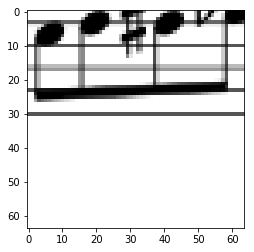

In [7]:
NNN=501
plt.imshow(train_score_images[NNN].reshape(64,64),cmap="gray")

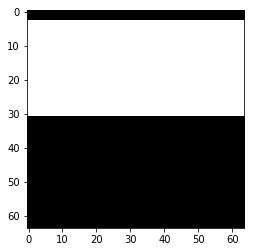

In [8]:
plt.imshow(train_mask_images[NNN].reshape(64,64),cmap="gray")

Make the Model & Do some Training
-----

Just a few epochs to see how things go.

In [12]:
input_shape = (rows,cols,channels)
batch_size  = 32
num_epochs  = 20
train_rate  = 1e-4
num_labels  = 2 

In [13]:
train_generator = image_generator(train_score_images, train_mask_images, batch_size, channels)
valid_generator = image_generator(valid_score_images, valid_mask_images, batch_size, channels)

In [14]:
image_input = Input(shape=input_shape)
x = create_tiramisu_model(num_labels, image_input, 
                          nb_layers_per_block=[4,5,7,10,12],
                          initial_filter=48, bottleneck_filter=15, growth_rate=16,
                          do_td_maxpool=False,
                          p=0.2, wd=1e-4)
model = Model(image_input, x)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(train_rate), 
              metrics=["accuracy"])

In [15]:
model.fit_generator(train_generator, 
                    num_train_images//batch_size, num_epochs, 
                    verbose=2,
                    validation_data=valid_generator,
                    validation_steps=num_valid_images//batch_size)


Epoch 1/20
27s - loss: 10.9791 - acc: 0.3546 - val_loss: 11.1092 - val_acc: 0.3333
Epoch 2/20
21s - loss: 10.8090 - acc: 0.3604 - val_loss: 10.8976 - val_acc: 0.3557
Epoch 3/20
21s - loss: 4.6621 - acc: 0.7248 - val_loss: 1.7459 - val_acc: 0.9168
Epoch 4/20
21s - loss: 1.3639 - acc: 0.9400 - val_loss: 1.0072 - val_acc: 0.9670
Epoch 5/20
21s - loss: 1.0288 - acc: 0.9647 - val_loss: 0.9839 - val_acc: 0.9678
Epoch 6/20
21s - loss: 0.8998 - acc: 0.9738 - val_loss: 1.1267 - val_acc: 0.9592
Epoch 7/20
22s - loss: 0.8331 - acc: 0.9785 - val_loss: 0.8773 - val_acc: 0.9754
Epoch 8/20
21s - loss: 0.7574 - acc: 0.9834 - val_loss: 0.8637 - val_acc: 0.9764
Epoch 9/20
21s - loss: 0.7468 - acc: 0.9836 - val_loss: 0.7920 - val_acc: 0.9804
Epoch 10/20
21s - loss: 0.6923 - acc: 0.9871 - val_loss: 0.6926 - val_acc: 0.9868
Epoch 11/20
21s - loss: 0.6632 - acc: 0.9888 - val_loss: 0.6956 - val_acc: 0.9865
Epoch 12/20
21s - loss: 0.6291 - acc: 0.9908 - val_loss: 0.7147 - val_acc: 0.9841
Epoch 13/20
21s - los

Cool, the above output pretty closely matches the below output so the code changes seem good.

Continuing to adjust code... 
Wow, changing to separate dense_block_up/down makes big difference to runtime.
now 22s/epoch & was 32s/epoch!  

Comparison to original working code:
```
Epoch 1/20
38s - loss: 11.0899 - acc: 0.3514 - val_loss: 11.1410 - val_acc: 0.3294
Epoch 2/20
32s - loss: 10.9127 - acc: 0.3562 - val_loss: 10.9368 - val_acc: 0.3515
Epoch 3/20
32s - loss: 10.7670 - acc: 0.3621 - val_loss: 10.9091 - val_acc: 0.3532
Epoch 4/20
32s - loss: 10.6393 - acc: 0.3684 - val_loss: 7.6373 - val_acc: 0.5500
Epoch 5/20
31s - loss: 3.6307 - acc: 0.7933 - val_loss: 1.4512 - val_acc: 0.9345
Epoch 6/20
31s - loss: 1.2234 - acc: 0.9497 - val_loss: 0.8745 - val_acc: 0.9730
Epoch 7/20
32s - loss: 0.9837 - acc: 0.9659 - val_loss: 0.7437 - val_acc: 0.9817
Epoch 8/20
32s - loss: 0.8285 - acc: 0.9757 - val_loss: 0.7250 - val_acc: 0.9811
Epoch 9/20
31s - loss: 0.7660 - acc: 0.9796 - val_loss: 0.6584 - val_acc: 0.9861
Epoch 10/20
31s - loss: 0.7029 - acc: 0.9832 - val_loss: 0.6142 - val_acc: 0.9891
Epoch 11/20
31s - loss: 0.6489 - acc: 0.9869 - val_loss: 0.5900 - val_acc: 0.9905
Epoch 12/20
32s - loss: 0.6206 - acc: 0.9883 - val_loss: 0.6310 - val_acc: 0.9871
Epoch 13/20
31s - loss: 0.5986 - acc: 0.9898 - val_loss: 0.5452 - val_acc: 0.9929
Epoch 14/20
31s - loss: 0.5825 - acc: 0.9902 - val_loss: 0.5657 - val_acc: 0.9909
Epoch 15/20
31s - loss: 0.5607 - acc: 0.9915 - val_loss: 0.5438 - val_acc: 0.9917
Epoch 16/20
31s - loss: 0.5384 - acc: 0.9926 - val_loss: 0.5082 - val_acc: 0.9941
Epoch 17/20
30s - loss: 0.5221 - acc: 0.9934 - val_loss: 0.4810 - val_acc: 0.9960
Epoch 18/20
30s - loss: 0.5113 - acc: 0.9937 - val_loss: 0.4792 - val_acc: 0.9955
Epoch 19/20
30s - loss: 0.4960 - acc: 0.9944 - val_loss: 0.4742 - val_acc: 0.9957
Epoch 20/20
30s - loss: 0.4788 - acc: 0.9951 - val_loss: 0.4865 - val_acc: 0.9946
```

Check results:
----

In [ ]:
NNN=503
pred_result = model.predict(train_score_images[NNN:NNN+1])
pred_result = pred_result.reshape(1,64,64,2)
pred_zero,pred_one = pred_result[:,:,:,0], pred_result[:,:,:,1]

In [ ]:
#plt.imshow(train_score_images[NNN].reshape(64,64),cmap="gray")
plt.imshow(pred_one.reshape(64,64),cmap="gray")

*results were prettty good here, but didn't save those cells.*

The edges were not straight so let's keep training... 

In [ ]:
train_rate = 1e-5
num_epochs = 20
model.optimizer=keras.optimizers.RMSprop(train_rate, decay=1-0.9995)
model.fit_generator(train_generator, 
                    num_train_images//batch_size, num_epochs, 
                    verbose=2,
                    validation_data=valid_generator,
                    validation_steps=num_valid_images//batch_size)

In [ ]:
NNN=505
pred_result = model.predict(train_score_images[NNN:NNN+1])
pred_result = pred_result.reshape(1,64,64,2)
pred_zero,pred_one = pred_result[:,:,:,0], pred_result[:,:,:,1]

In [ ]:
plt.imshow(train_score_images[NNN].reshape(64,64),cmap="gray")

In [ ]:
plt.imshow(pred_one.reshape(64,64),cmap="gray")

Nice Results
------------

Save those weights, but this wasn't much effort so let's keep going.

In [ ]:
#!mkdir data/results
model.save_weights('data/results/mask_weights_171011_1.h5')

In [ ]:
train_rate = 1e-5
num_epochs = 20
model.optimizer=keras.optimizers.RMSprop(train_rate, decay=1-0.9995)
model.fit_generator(train_generator, 
                    num_train_images//batch_size, num_epochs, 
                    verbose=2,
                    validation_data=valid_generator,
                    validation_steps=num_valid_images//batch_size)

In [ ]:
model.save_weights('data/results/mask_weights_171011_2.h5')

In [ ]:
NNN=1060
pred_result = model.predict(train_score_images[NNN:NNN+1])
pred_result = pred_result.reshape(1,64,64,2)
pred_zero,pred_one = pred_result[:,:,:,0], pred_result[:,:,:,1]

In [ ]:
plt.imshow(pred_one.reshape(64,64),cmap="gray")

Let's use model
------

Read in full image, dice it up, predict output for each bit, reassemble into a full image.

In [ ]:
def get_image_names(base_name):
    score_file_name = f'../data/{base_name}.png'
    mask_file_name = f'../data/{base_name}_mask.png'
    return score_file_name, mask_file_name

def get_images(base_name):
    score_file_name, mask_file_name = get_image_names(base_name)
    mask_image = Image.open(mask_file_name).convert('L')
    mask_image = Image.eval(mask_image, lambda x: x*10) # saturate the mask
    score_image = Image.open(score_file_name)
    background = Image.new('RGBA', score_image.size, (255,255,255))
    score_image = Image.alpha_composite(background,score_image)
    score_image = score_image.convert('L')
    return score_image, mask_image

In [ ]:
def get_input_prediction_tiles(input_image):
    # cannot just send an image to predict.  We have to send the tiles
    # pred_result = model.predict(score_image)
    #   ValueError: Error when checking : expected input_1 to have shape (None, 64, 64, 1) 
    #   but got array with shape (1, 1123, 794, 1)
    num_tiles = np.ceil(np.array([input_image.width/64,input_image.height/64]))
    tot_tiles = int(num_tiles[0]*num_tiles[1])
    input_tiles = np.zeros((tot_tiles,64,64,1),dtype='uint8')
    i = 0
    for iy in range(int(num_tiles[1])):
        for ix in range(int(num_tiles[0])):
            input_tiles[i] = np.array(score_image.crop([ix*64,iy*64,(ix+1)*64,(iy+1)*64])).reshape(64,64,1)
            i += 1
    return input_tiles

def image_from_tiles(width,height,pred_tiles,pred_channel):
    # reshape & collect a single channel plane to visualize
    pred_tiles = pred_tiles.reshape(input_tiles.shape[0],64,64,2)
    pred_one_tiles = pred_tiles[:,:,:,1]#pred_one = pred_one.reshape(int(num_tiles[0])*64,int(num_tiles[1])*64)
    num_tiles = np.ceil(np.array([width/64,height/64]))
    pred_one = Image.new('L', (int(num_tiles[0])*64,int(num_tiles[1])*64), (0,))
    i = 0
    for iy in range(int(num_tiles[1])):
        for ix in range(int(num_tiles[0])):
            pred_tile_image = Image.fromarray(np.uint8(pred_one_tiles[i]*255))
            pred_one.paste(pred_tile_image, (ix*64,iy*64))
            i += 1
    return pred_one


In [ ]:
score_image, mask_image = get_images('gen_two')
input_tiles = get_input_prediction_tiles(score_image)
pred_tiles = model.predict(input_tiles)
pred_one = image_from_tiles(score_image.width, score_image.height, pred_tiles, 1)

Visualize the output
----------

Look's likely to be acceptable!  There are definitely some glitches, but I think these are 
results that would work for finding the regions to focus on.

In [ ]:
pred_one

In [ ]:
# for comparison, look at either of these...
#score_image
mask_image

In [ ]:
# just some debug snippets
ix, iy = 10, 0
img = np.array(score_image.crop([ix*64,iy*64,(ix+1)*64,(iy+1)*64])).reshape(64,64,1)
plt.imshow(img.reshape(64,64),cmap="gray")
#img[0,:10]

In [ ]:
plt.imshow(input_tiles[10].reshape(64,64),cmap="gray")